"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes."<https://www.kaggle.com/zalando-research/fashionmnist>  
### ※Labels are;
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import chainer 
import chainer.functions as F
import chainer.links as L
from chainer import computational_graph
from chainer import serializers

In [4]:
mnist_train = pd.read_csv('fashion_mnist_train.csv')
mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = np.array(mnist_train.iloc[:, 1:])
y = np.array(mnist_train.iloc[:, 0])
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [7]:
X = X.astype(np.float32)
y = y.astype(np.int32)

In [8]:
X.shape

(60000, 784)

In [9]:
y.shape

(60000,)

In [10]:
#画像の正規化
X /= 255.

In [11]:
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

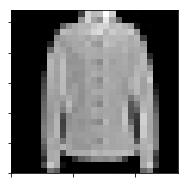

In [12]:
#画像の確認
index  = 50000
draw_digit(X[index])

今回は用意されているtrainデータをホールド・アウト法にて分割し、20%をテストデータとして学習を行い、用意されているtestデータで最終的なモデルのaccuracyを求めることにする。

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
len(X_train)

48000

# ニューラルネットワーク

In [15]:
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 900)  
            self.l2=L.Linear(900, 1000) 
            self.l3=L.Linear(1000, 500) 
            self.l4=L.Linear(500, 10)   
        
    
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  
        h2 = F.relu(self.l2(h1)) 
        h3 = F.relu(self.l3(h2)) 
        return self.l4(h3)       # 出力層への入力を返す

In [16]:
# 分類器インスタンスの生成
# MLPクラスのインスタンスを引数として渡す
model = L.Classifier(MLP())

In [28]:
# optimizerの定義; SGDを使用
optimizer = chainer.optimizers.SGD() 
optimizer.setup(model)                # モデルを読み込ませる

In [29]:
# ミニバッチに含まれるサンプル数を指定
# データからサンプルを100個ずつ取り出して学習する
batch_size = 100
# epoch数を指定
n_epoch = 20

In [30]:
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [31]:
# X_trainとy_trainをTupleDatasetにまとめる
train = tuple_dataset.TupleDataset(X_train, y_train)

In [32]:
# train_iterを生成
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [33]:
# Updataerを生成
#度のデータを参照して、どのモデルと最適化手法でパラメータを更新するか
# 今回はCPUの利用を想定
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [34]:
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [35]:
# testデータをTupleDatasetに変換
test = tuple_dataset.TupleDataset(X_test,y_test)
# test_iterを生成
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)
# Evaluatorクラスをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter, model))
# Evaluatorクラスをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter, model))
# ログファイルを作成する機能を追加
trainer.extend(extensions.LogReport())
# 学習状況の報告を逐一出力する機能を追加
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))
# trainとtestの精度のグラフを出力。第1引数にグラフの縦軸に採用する項目を､第2引数に'epoch'を与えて横軸を指定し､第3引数にfile_name(出力される画像ファイルのファイル名）
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
# 進捗報告をする機能を追加
# trainer.extend(extensions.ProgressBar())

In [36]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           0.103282    0.960646       0.364935              0.90125                   
2           0.0918646   0.965083       0.367228              0.903                     
3           0.0882384   0.966063       0.369445              0.90375                   
4           0.085748    0.966875       0.369335              0.904                     
5           0.083926    0.9675         0.373994              0.904417                  
6           0.0826435   0.968167       0.377652              0.90325                   
7           0.081415    0.968188       0.378973              0.903917                  
8           0.080314    0.969313       0.37783               0.903667                  
9           0.0793653   0.969146       0.378874              0.90375                   
10          0.0784564   0.969521       0.384535              0.904167                  
11          0.0776736   0.969563  

In [26]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

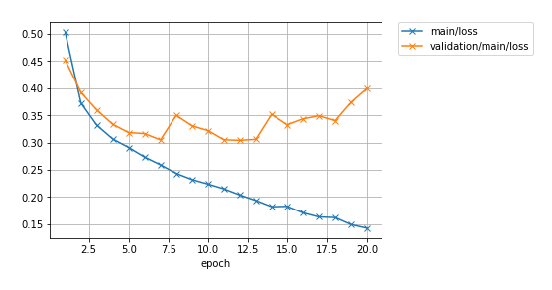

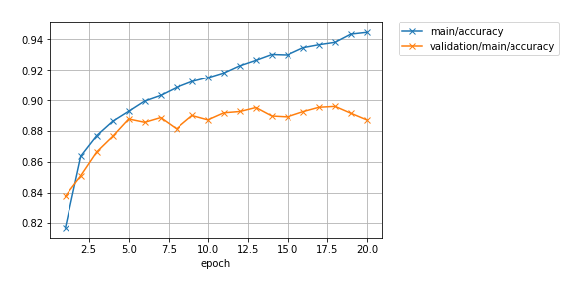

In [27]:
# 誤差と精度のグラフを描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

適切なモデルは５−７epoch周辺のものだとわかる。

In [38]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [39]:
# 混同行列を出力
# testデータに対して行うことに注意
from sklearn.metrics import confusion_matrix as cm
result = predict(model, X_test)
cm(result, y_test)

array([[1023,    4,   11,   30,    3,    3,  145,    0,    6,    0],
       [   0, 1176,    0,   10,    0,    0,    2,    0,    1,    0],
       [  19,    2, 1012,    9,  107,    0,   72,    0,    1,    0],
       [  20,    6,    6, 1143,   30,    3,   23,    0,    3,    0],
       [   2,    0,   96,   51, 1009,    0,   71,    0,    5,    0],
       [   0,    0,    0,    0,    0, 1151,    0,    8,    0,   12],
       [ 121,    1,   77,   15,   58,    0,  879,    0,   13,    0],
       [   0,    0,    0,    0,    0,   19,    0, 1121,    3,   38],
       [   4,    0,    2,    2,    1,    4,    3,    3, 1177,    1],
       [   0,    0,    0,    0,    0,    8,    0,   28,    1, 1146]])

In [42]:
# 混同行列をグラフで出力する関数
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(np.arange(0, 10, 1)) # x軸の目盛りを指定
    plt.yticks(np.arange(0, 10, 1)) # y軸の目盛りを指定
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

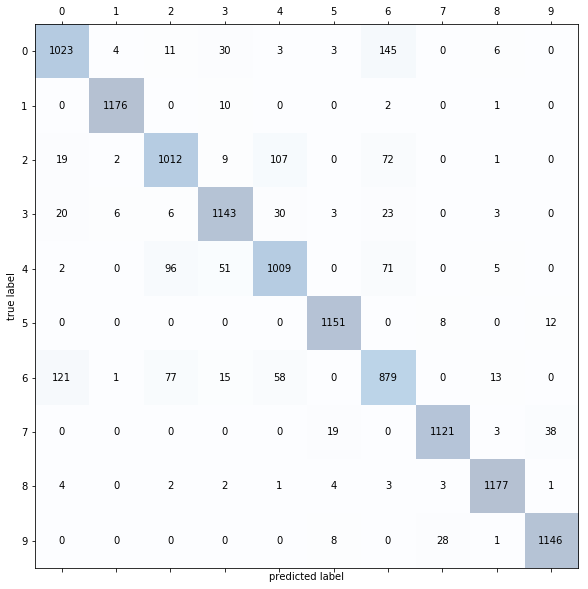

In [43]:
# 混同行列をグラフで出力
# testデータに対して行うことに注意
plot_cm(result, y_test)

In [44]:
# 性能指標を確認
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.903
recall: 0.903
precision: 0.904
f1_score: 0.903


In [45]:
# モデルの保存
# (ファイル名, 保存したいモデルの変数名)
serializers.save_npz('mnist.model', model)
print('Saved the model.')

Saved the model.
